In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from sklearn.model_selection import StratifiedKFold, train_test_split

from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores, find_all
import shap
shap.initjs()

import torch
from ml.models.autoencoder import AutoEncoder
from ml.models.mlp import MLP
import joblib

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(df)

700519

In [5]:
X_train = df.drop('target', axis=1)

# Specify the AutoEncoder

In [6]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[64],
    out_size=32,
    vae=False) # do not use VAE
decoder = MLP(
    in_size=32, 
    layer_units=[64],
    out_size=X_train.shape[1]
)
classifier = MLP(
    in_size=X_train.shape[1],
    layer_units=[32, 64],
    out_size=1,
    init_weights=False
)

ae_model = AutoEncoder(encoder, decoder, classifier=classifier) # make it an AutoEncoder-based classifier.
ae_model.load_state_dict(torch.load("../checkpoints/autoencoder_classifier.pth"))
ae_model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=88, bias=True)
    )
  )
  (classifier): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [7]:
ae_model.encoder.MLP[0].weight

Parameter containing:
tensor([[-0.4329, -1.4976, -1.0692,  ...,  0.2815, -0.0571,  0.0027],
        [ 0.0368,  1.2660,  0.8166,  ..., -0.1324, -0.0947, -0.4421],
        [ 0.0137, -0.0112,  0.1332,  ..., -0.3050, -0.1187, -0.3729],
        ...,
        [-0.1146, -0.3185,  0.2643,  ...,  0.0496,  0.0541,  0.7581],
        [-0.0111, -0.8712, -0.5375,  ...,  0.9057,  0.4082,  1.1457],
        [-0.4022,  0.5564, -0.6535,  ...,  0.5270,  0.1689,  0.2248]],
       requires_grad=True)

# Scale the features for the AutoEncoder

In [8]:
scaler = joblib.load('../checkpoints/minmax_scaler.joblib')

tmp_df = df.copy()

X = tmp_df.drop(['target'], axis=1)
X = scaler.transform(X)

y = tmp_df['target'].values

cols = list(df.columns)
cols.remove("target")

tmp = pd.DataFrame(X, columns=cols)
tmp['target'] = y

In [9]:
def get_hidden(row, model):
    model.eval()
    model.to('cpu') # move model to cpu
    if 'target' in row:
        tmp_X = row.drop('target') # get the features
    else:
        tmp_X = row
    
    input_tensor = torch.tensor(tmp_X.values, dtype=torch.float32) # transform to torch tensor
    
    encoded = model.encode(input_tensor) # get the latent
    
    return -1., encoded.detach().numpy().tolist()

# Generate latents

In [10]:
tmp[['tmp', 'hidden']] = tmp.apply(lambda row: pd.Series(get_hidden(row, ae_model)), axis=1)
tmp.drop(['tmp'], axis=1, inplace=True)

In [11]:
len(tmp)

700519

In [12]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.48368293046951294, 0.6294888854026794, -0...."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0620262622833252, 1.4297322034835815, -0.89..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.394878625869751, 0.93348628282547, -0.77943..."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.1152064800262451, -0.954816997051239, 1.25..."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.067033290863037, 0.11420591175556183, 0.42..."


# Merge the original features with latents

In [13]:
tmp2 = pd.DataFrame(tmp['hidden'].apply(pd.Series).values, columns=[f't_hidden_{i}' for i in range(1, 33)])

In [14]:
tmp2.head()

,t_hidden_1,t_hidden_2,t_hidden_3,t_hidden_4,t_hidden_5,t_hidden_6,t_hidden_7,t_hidden_8,t_hidden_9,t_hidden_10,...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,-0.483683,0.629489,-0.671883,2.340456,-1.119921,0.751722,-2.390941,0.793149,-1.012193,1.343351,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,1.062026,1.429732,-0.895177,1.342135,-1.308776,0.491307,-1.911441,-0.105718,0.083288,-0.173033,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,0.394879,0.933486,-0.779438,1.378915,-0.666496,-0.165693,-1.799483,0.221670,-0.803395,0.448730,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,-1.115206,-0.954817,1.257394,-0.239497,-0.833400,0.729702,-1.049405,-0.621937,-1.043372,-0.487578,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,-1.067033,0.114206,0.421715,0.403044,-0.213622,0.349254,-1.218946,-0.207542,-0.499051,0.041179,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [15]:
len(tmp2), len(df)

(700519, 700519)

In [16]:
df.reset_index(drop=True, inplace=True)
tmp2.reset_index(drop=True, inplace=True)
tmp3 = df.join(tmp2)

In [17]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [18]:
len(tmp3), len(df)

(700519, 700519)

In [19]:
print(len(df))
df = tmp3.copy()
df = df.drop_duplicates()
print(len(df))

700519
700519


# Training function

In [20]:
def train(model, X, y, cols):
    scaler = MinMaxScaler()
    print("Classifier: CATBOOST")
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))

    corrects = dict()
    lifts = dict()

    scaler.fit(X)
    X = scaler.transform(X)
        
    print("Shape", X.shape)
         
    print("bins", np.bincount(y))

    model.fit(X, y, verbose=False)

    y_pred = model.predict(X)

    acc, precision, recall, f1 = get_classification_metrics(y.values, y_pred)

    y_scores = model.predict_proba(X)
    idx = np.argmax(y_scores, axis=1)
    y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


    brier, roc_auc, pr_auc = get_probability_measures(y.values, y_scores)

    num_ones = np.sum(y == 1)


    s1 = int(0.1 * num_ones)
    s2 = int(0.2 * num_ones)
    s3 = int(0.3 * num_ones)
    s4 = int(0.4 * num_ones)
    s5 = int(0.5 * num_ones)
    s6 = int(0.6 * num_ones)
    s7 = int(0.7 * num_ones)
    s8 = int(0.8 * num_ones)
    s9 = int(0.9 * num_ones)
    s10 = int(1 * num_ones)

    lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s1)
    lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s2)
    lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s3)
    lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s4)
    lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s5)
    lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s6)
    lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s7)
    lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s8)
    lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s9)
    lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=s10)
            
    lift100, demotion100, weighted_score100 = get_lift_demotion_scores(y.values, y_scores,
                                                                        num_samples=100)

    print(f"At 100 samples -- Lift: {lift100:.4f}, Demotion: {demotion100:.4f}, Weighted: {weighted_score100:.4f}")
    sorted_scores = np.argsort(y_scores.reshape(1, -1)[0])
    top_indices_lift = sorted_scores[-1500:]
    lifts["catboost"] = top_indices_lift
    print("Top 10 scores:", y_scores[top_indices_lift][-10:])

    print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
    print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
    print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
    print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
    print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
    print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
    print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
    print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
    print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
    print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

    print("")
    #find_all(y.values, y_scores,)
    print("")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
    plt.tight_layout()
    plt.show()
    plt.close()
        
    y = y.values
        
    for clf in lifts:
        lifts[clf] = np.flip(lifts[clf])
    correct, incorrect = dict(), dict()
    for clf in lifts:
        correct[clf] = dict()
        incorrect[clf] = dict()
        for i, pred_idx in enumerate(lifts[clf]):
            if y[pred_idx] == 1:
                correct[clf][i] = pred_idx
            else:
                incorrect[clf][i] = pred_idx
    corrects[0] = correct
        
    
    
    return model, scaler, corrects

# CatBoost Params

In [21]:
catboost_params = {
    'iterations': 638,
    'learning_rate': 0.025523589056371577,
    'depth': 10,
    'l2_leaf_reg': 6.796852560556034,
    'bootstrap_type': 'Bernoulli',
    'border_count': 117,
    'random_strength': 5.825154439482673e-06,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 17,
    'colsample_bylevel': 0.05182138006830478,
    'objective': 'CrossEntropy',
    'subsample': 0.9623661384375424,
    'random_state': 42
}

In [22]:
clf = CatBoostClassifier(**catboost_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
Shape (700519, 120)
bins [698967   1552]
At 100 samples -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
Top 10 scores: [0.96633569 0.96724193 0.96790833 0.96828432 0.97007587 0.97109267
 0.97120823 0.97131706 0.9741949  0.9852832 ]
0.1 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.2 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.3 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.4 -- Lift: 0.9774, Demotion: 1.0000, Weighted: 0.9842
0.5 -- Lift: 0.9021, Demotion: 1.0000, Weighted: 0.9314
0.6 -- Lift: 0.8131, Demotion: 1.0000, Weighted: 0.8692
0.7 -- Lift: 0.7357, Demotion: 1.0000, Weighted: 0.8150
0.8 -- Lift: 0.6648, Demotion: 1.0000, Weighted: 0.7654
0.9 -- Lift: 0.6074, Demotion: 1.0000, Weighted: 0.7252
1 -- Lift: 0.5619, Demotion: 1.0000, Weighted: 0.6933




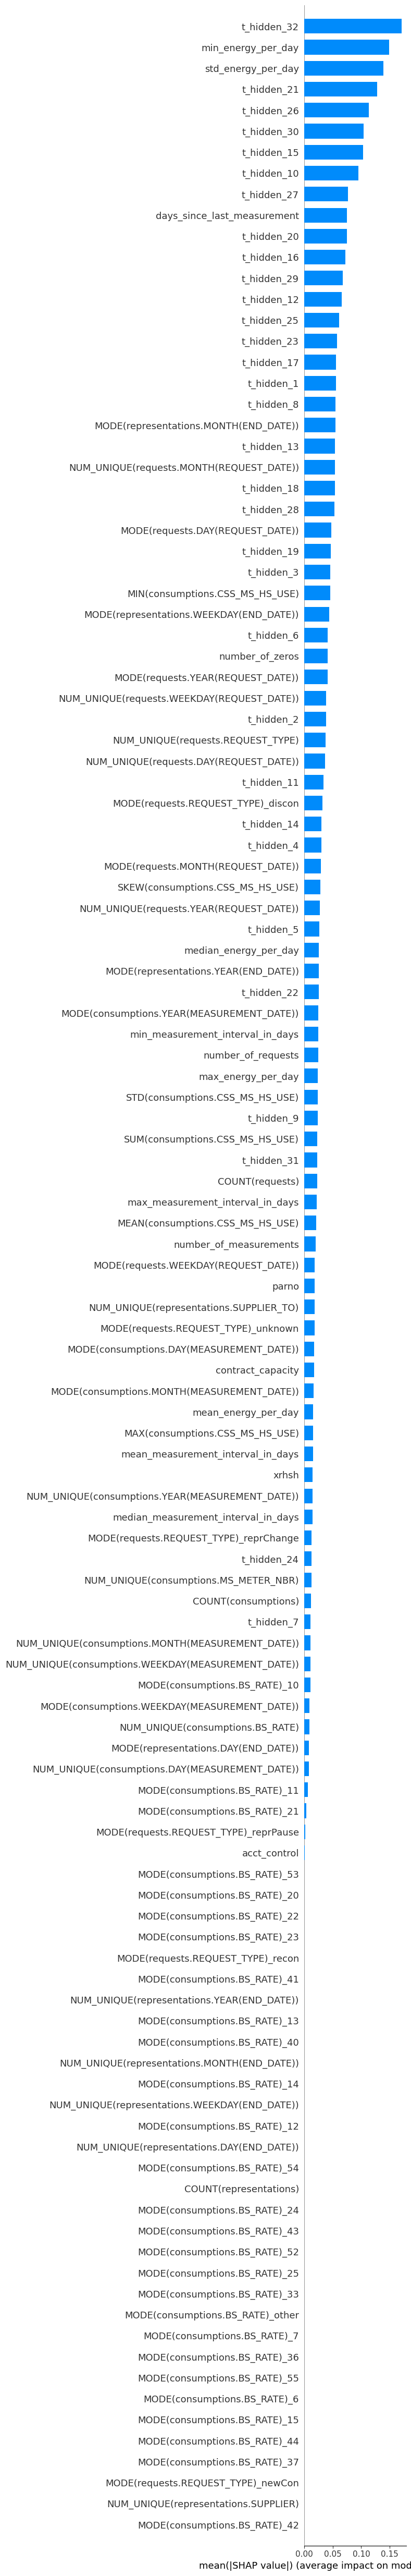

In [23]:
X = df.drop(['target'], axis=1)
y = df['target']
cols = list(df.columns)
cols.remove('target')
model, scaler, correct = train(clf, X, y, cols)

# Mini top 100 Analysis

Fold 0


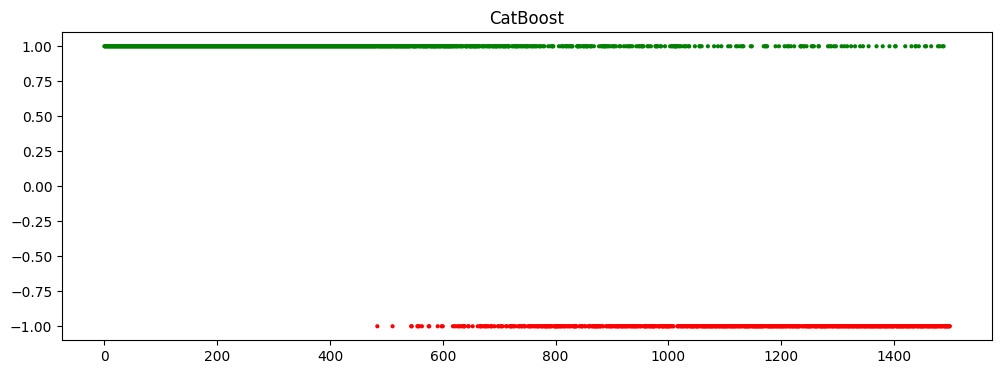

In [24]:
for k in correct:
    print("Fold", k)
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    split_correct = correct[k]
    
    preds = []
    for i in range(1500):
        if i in split_correct["catboost"].keys():
            preds.append(1)
        else:
            preds.append(-1)
    colors = ['green' if x == 1 else 'red' for x in preds]
    ax.scatter(range(len(preds)), preds, c=colors, s=4)
    ax.set_title(f'CatBoost')

    plt.show()
    plt.close()

In [25]:
for k in correct:
    print("\n\nFold", k)
    split_correct = correct[k]
    for clf in split_correct:
        print(f"{clf} found {len(split_correct[clf].keys())} correct")



Fold 0
catboost found 862 correct


In [26]:
joblib.dump(scaler, "../checkpoints/catboost_minmax_scaler.joblib")
joblib.dump(model, "../checkpoints/catboost_classifier.joblib")

['../checkpoints/catboost_classifier.joblib']